In [1]:
import os
import sys
import json
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

from opts import parse_opts
from mean import get_mean, get_std
from spatial_transforms import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose
from dataset import get_training_set, get_validation_set, get_test_set
from utils import Logger
from train import train_epoch
from validation import val_epoch
import test
import collections
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from joblib import dump, load
from sklearn import preprocessing
from scipy import stats
from sklearn.metrics import accuracy_score

from models import *

In [2]:
import easydict
opt = easydict.EasyDict({
    "result_path": 'results2',
    "dataset": 'ucf101-music', # 'ucf101',
    "n_classes": 9, 
    "sample_size": 112,
    "sample_duration": 16,
    "initial_scale": 1.0,
    "n_scales": 5,
    "scale_step": 0.84089641525,
    "train_crop": 'corner',
    "learning_rate": 0.1,
    "momentum": 0.9,
    "dampening": 0.9,
    "weight_decay": 0.001,
    "mean_dataset": 'activitynet',
    "no_mean_norm": False,
    "std_norm": False,
    "nesterov": False,
    "optimizer": 'sgd',
    "lr_patience": 10,
    "batch_size": 16,
    "n_epochs": 2,
    "begin_epoch": 1,
    "n_val_samples": 3,
    "ft_begin_index": 5,
    "scale_in_test": 1.0,
    "crop_position_in_test": 'c',
    "no_softmax_in_test": False,
    "no_cuda": False,
    "n_threads": 4,
    "checkpoint": 2,
    "no_hflip": False,
    "norm_value": 1,
    "model": 'resnet',
    "pretained_model_name": 'resnext-101-kinetics',
    "model_depth": 101,
    "resnet_shortcut": 'B',
    "wide_resnet_k": 2,
    "resnext_cardinality": 32,
    "manual_seed": 1,
    'test_subset': 'test',
})
opt.arch = '{}-{}'.format(opt.model, opt.model_depth)
opt.root_path = '/data/qq/CSCE689/video/'
opt.video_path = opt.root_path + 'UCF-music/'
opt.annotation_path = opt.root_path+'UCF-music-annotation/ucf101_music_with_testing.json'

In [3]:
# use two gpu devices on the server, you can customize it depending on how many available gpu devices you have
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [4]:
from models import resnext

# construct model architecture
model = resnext.resnet101(
            num_classes=opt.n_classes,
            shortcut_type=opt.resnet_shortcut,
            cardinality=opt.resnext_cardinality,
            sample_size=opt.sample_size,
            sample_duration=opt.sample_duration)

model = model.cuda()
# wrap the current model again in nn.DataParallel / or we can just remove the .module keys.
model = nn.DataParallel(model, device_ids=None)

# load best weight (we can also refit the model on the combined train-val dataset, 
# but here we simple load the weight and do the final testing)
pretrain = torch.load('./results1/save_200.pth')
model.load_state_dict(pretrain['state_dict'])


/home/qq/CSCE689/3D-ResNets-PyTorch/models/resnext.py:121: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


<All keys matched successfully>

In [5]:
from datasets.ucf101 import UCF101

mean = get_mean(opt.norm_value, dataset='kinetics')
std = get_std(opt.norm_value)
norm_method = Normalize(mean, [1,1,1])


spatial_transform = Compose([
    Scale(opt.sample_size),
    CornerCrop(opt.sample_size, 'c'),
    ToTensor(opt.norm_value), norm_method
])

temporal_transform = LoopPadding(opt.sample_duration)
target_transform = VideoID() # ClassLabel()



# get test data
test_data = UCF101(
    opt.video_path,
    opt.annotation_path,
    'testing',
    0,
    spatial_transform=spatial_transform,
    temporal_transform=temporal_transform,
    target_transform=target_transform,
    sample_duration=16)


# wrap test data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_threads,
    pin_memory=False)


dataset loading [0/149]


In [6]:
from testing import final_test
test_results, all_output_buffer = final_test(test_loader, model, opt, test_data.class_names)

test


/home/qq/CSCE689/3D-ResNets-PyTorch/testing.py:44: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs = Variable(inputs, volatile=True)
/home/qq/CSCE689/3D-ResNets-PyTorch/testing.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(outputs)


[1/162]	Time 1.416 (1.416)	Data 1.268 (1.268)	
[2/162]	Time 0.120 (0.768)	Data 0.010 (0.639)	
[3/162]	Time 0.108 (0.548)	Data 0.009 (0.429)	
[4/162]	Time 0.107 (0.438)	Data 0.008 (0.324)	
[5/162]	Time 0.495 (0.449)	Data 0.401 (0.339)	
[6/162]	Time 0.109 (0.392)	Data 0.008 (0.284)	
[7/162]	Time 0.111 (0.352)	Data 0.013 (0.245)	
[8/162]	Time 0.105 (0.321)	Data 0.007 (0.216)	
[9/162]	Time 0.471 (0.338)	Data 0.369 (0.233)	
[10/162]	Time 0.109 (0.315)	Data 0.009 (0.210)	
[11/162]	Time 0.114 (0.297)	Data 0.016 (0.193)	
[12/162]	Time 0.103 (0.281)	Data 0.009 (0.177)	
[13/162]	Time 0.542 (0.301)	Data 0.438 (0.197)	
[14/162]	Time 0.109 (0.287)	Data 0.014 (0.184)	
[15/162]	Time 0.107 (0.275)	Data 0.007 (0.172)	
[16/162]	Time 0.111 (0.265)	Data 0.008 (0.162)	
[17/162]	Time 0.479 (0.277)	Data 0.378 (0.175)	
[18/162]	Time 0.102 (0.268)	Data 0.008 (0.166)	
[19/162]	Time 0.106 (0.259)	Data 0.010 (0.157)	
[20/162]	Time 0.113 (0.252)	Data 0.013 (0.150)	
[21/162]	Time 0.350 (0.256)	Data 0.255 (0.155)	
[

In [26]:
examples = ['v_PlayingGuitar_g05_c03', 
            'v_PlayingViolin_g03_c03', 
            'v_PlayingCello_g07_c05', 
            'v_PlayingFlute_g07_c04',
            'v_PlayingPiano_g01_c02']

### Extract clip duration

In [47]:
avi_path = "/data/qq/CSCE689/video/UCF-101"
clip_duration_dict = {}
real_prediction_dict = {}
import os
from moviepy.editor import VideoFileClip
for tvn in test_results['results']:
    clip = VideoFileClip(os.path.join(avi_path, tvn[2:-8], tvn + ".avi"))
    clip_duration_dict[tvn] = [clip.duration, all_output_buffer[tvn]]
    real_prediction_dict[tvn] = test_results['results'][tvn][0]

### Generate prediction plot for each video 

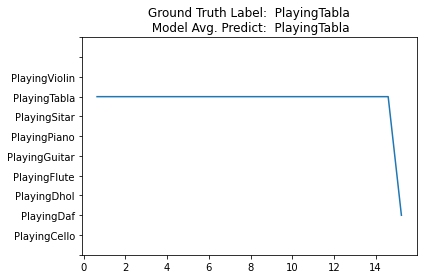

In [103]:
import matplotlib.pyplot as plt
import numpy as np

for tvn in test_results['results']:
    interval = clip_duration_dict[tvn][0]/len(clip_duration_dict[tvn][1])
    x = np.arange(0, clip_duration_dict[tvn][0], interval) + interval
    y = np.array([np.argmax(pred) for pred in clip_duration_dict[tvn][1]]) + 1  # np.arange(len(test_data.class_names) + 1)
    my_yticks = [''] + list(test_data.class_names.values()) + ['']
    plt.plot(x, y)
    plt.yticks(np.arange(len(my_yticks) + 1), my_yticks)
    plt.title("Ground Truth Label:  " + tvn[2:-8]  + "\n Model Avg. Predict:  " + real_prediction_dict[tvn]['label'])
    plt.savefig("./figs/" + tvn, bbox_inches='tight')
    break

In [70]:
test_results['results']['v_PlayingTabla_g04_c04']

[{'label': 'PlayingTabla', 'score': 0.5185579657554626},
 {'label': 'PlayingSitar', 'score': 0.14087970554828644},
 {'label': 'PlayingDhol', 'score': 0.1273767501115799},
 {'label': 'PlayingDaf', 'score': 0.11835509538650513},
 {'label': 'PlayingPiano', 'score': 0.04172874987125397},
 {'label': 'PlayingFlute', 'score': 0.025170736014842987},
 {'label': 'PlayingViolin', 'score': 0.014937996864318848},
 {'label': 'PlayingGuitar', 'score': 0.008753728121519089},
 {'label': 'PlayingCello', 'score': 0.004239281173795462}]